In [ ]:
pip install transformers tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip show tensorflow


Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [3]:


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importer les bibliothèques nécessaires
from transformers import BertTokenizer, TFBertModel, GPT2Tokenizer, TFGPT2Model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Charger les modèles BERT Multilingue et GPT-2
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
gpt_model = TFGPT2Model.from_pretrained('gpt2')

# Charger les tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token  # GPT2 n'a pas de pad_token par défaut

# Charger et préparer le dataset
file_path = '/content/drive/MyDrive/data_balanced.csv'  # Modifier selon votre chemin
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df['Label'] = df['Label'].astype(str).str.strip().str.upper()
df['Label'] = df['Label'].apply(lambda x: 1 if x == 'TRUE' else 0)

texts = df['Statement'].tolist()
labels = np.array(df['Label'].tolist())

# Diviser les données en ensembles d'entraînement et de test
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)

# Fonction pour obtenir les embeddings BERT
def get_bert_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = bert_tokenizer(batch_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)
        outputs = bert_model(inputs).last_hidden_state[:, 0, :]  # Utiliser le token CLS comme embedding
        all_embeddings.append(outputs)
    return tf.concat(all_embeddings, axis=0)

# Fonction pour obtenir les embeddings GPT-2
def get_gpt_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = gpt_tokenizer(batch_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)
        outputs = tf.reduce_mean(gpt_model(inputs).last_hidden_state, axis=1)  # Moyenne des états cachés
        all_embeddings.append(outputs)
    return tf.concat(all_embeddings, axis=0)

# Obtenir les embeddings pour l'ensemble d'entraînement et de test
train_bert_embeddings = get_bert_embeddings(train_texts)
test_bert_embeddings = get_bert_embeddings(test_texts)
train_gpt_embeddings = get_gpt_embeddings(train_texts)
test_gpt_embeddings = get_gpt_embeddings(test_texts)

# Ajuster les dimensions avant la fusion si nécessaire
bert_dim = train_bert_embeddings.shape[-1]
gpt_dim = train_gpt_embeddings.shape[-1]# récupèrent la dernière dimension des tableaux d'embeddings générés par GPT
if bert_dim != gpt_dim:
    dense_layer = Dense(gpt_dim, activation='linear')#Création d'une couche dense pour l'ajustement des dimensions
    train_bert_embeddings = dense_layer(train_bert_embeddings)
    test_bert_embeddings = dense_layer(test_bert_embeddings)

# Fusionner les embeddings de BERT et GPT-2
train_combined_embeddings = tf.concat([train_bert_embeddings, train_gpt_embeddings], axis=-1)
test_combined_embeddings = tf.concat([test_bert_embeddings, test_gpt_embeddings], axis=-1)

# Normaliser et réduire la dimensionnalité
# Cette partie du code normalise les embeddings combinés
# (c'est-à-dire les vecteurs de caractéristiques provenant de BERT, GPT,
# ou d'autres modèles) afin de les amener à une échelle comparable (moyenne = 0, écart-type = 1). Cela est important pour améliorer la performance et la stabilité des modèles d'apprentissage automatique, en particulier ceux qui sont sensibles à l'échelle des données.
scaler = StandardScaler()
train_combined_embeddings = scaler.fit_transform(train_combined_embeddings.numpy())
test_combined_embeddings = scaler.transform(test_combined_embeddings.numpy())

pca = PCA(n_components=256)  # Réduction de dimension
train_combined_embeddings = pca.fit_transform(train_combined_embeddings)
test_combined_embeddings = pca.transform(test_combined_embeddings)

# Définir le modèle GBERT avec régularisation et bruit
inputs = Input(shape=(train_combined_embeddings.shape[-1],))
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = GaussianNoise(0.1)(x)
x = Dropout(0.5)(x)
classifier = Dense(2, activation='softmax')(x)
gbert_model = Model(inputs, classifier)

# Compiler le modèle
gbert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=["accuracy"])

# Callbacks une fois le model tembe dans ouverfiting la fonction stop cela ,Éviter le sur-apprentissage (overfitting).
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Préparer les datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_combined_embeddings, train_labels)).batch(64).shuffle(buffer_size=len(train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_combined_embeddings, test_labels)).batch(64)

# Entraîner le modèle
history = gbert_model.fit(train_dataset,
                          validation_data=test_dataset,
                          epochs=20,
                          callbacks=[early_stopping, reduce_lr])

# Évaluer le modèle
test_loss, test_accuracy = gbert_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Epoch 1/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8314 - loss: 2.1125 - val_accuracy: 0.9761 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 2/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9706 - loss: 0.2873 - val_accuracy: 0.9788 - val_loss: 0.1445 - learning_rate: 0.0010
Epoch 3/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9746 - loss: 0.1525 - val_accuracy: 0.9779 - val_loss: 0.1310 - learning_rate: 0.0010
Epoch 4/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9757 - loss: 0.1389 - val_accuracy: 0.9775 - val_loss: 0.1322 - learning_rate: 0.0010
Epoch 5/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9758 - loss: 0.1409 - val_accuracy: 0.9799 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 6/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9746 - loss: 0.1422 - val_accuracy: 0.9801 - val_loss: 0.1223 - learning_rate: 0.0010
Epoch 7/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9746 - loss: 0.1426 

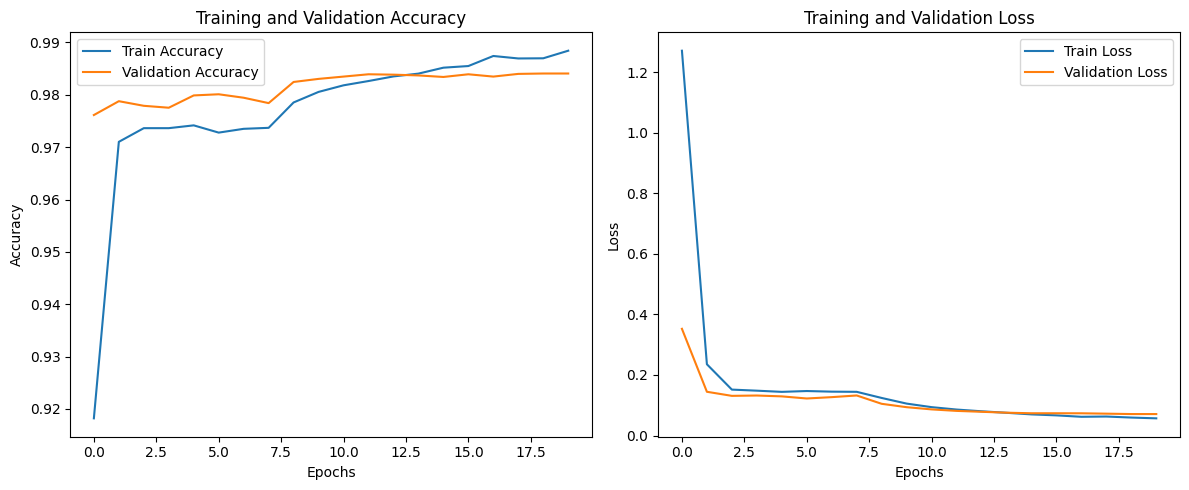

In [5]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)



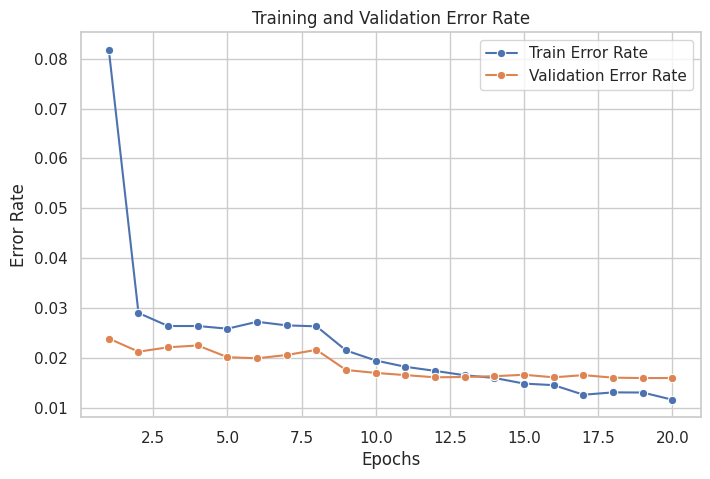

In [7]:

import seaborn as sns

def plot_classification_error(history):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    error_rate = 1 - np.array(history.history['accuracy'])
    val_error_rate = 1 - np.array(history.history['val_accuracy'])
    sns.lineplot(x=range(1, len(error_rate) + 1), y=error_rate, label='Train Error Rate', marker='o')
    sns.lineplot(x=range(1, len(val_error_rate) + 1), y=val_error_rate, label='Validation Error Rate', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.title('Training and Validation Error Rate')
    plt.legend()
    plt.show()

plot_classification_error(history)



213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


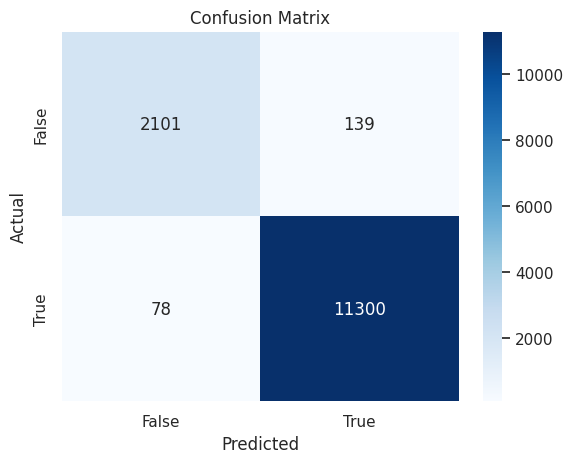

In [10]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, predictions):
    predicted_labels = np.argmax(predictions, axis=1)
    conf_matrix = confusion_matrix(labels, predicted_labels)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Generate predictions on the test dataset
test_predictions = gbert_model.predict(test_dataset)

# Now call the function with the predictions
plot_confusion_matrix(test_labels, test_predictions)

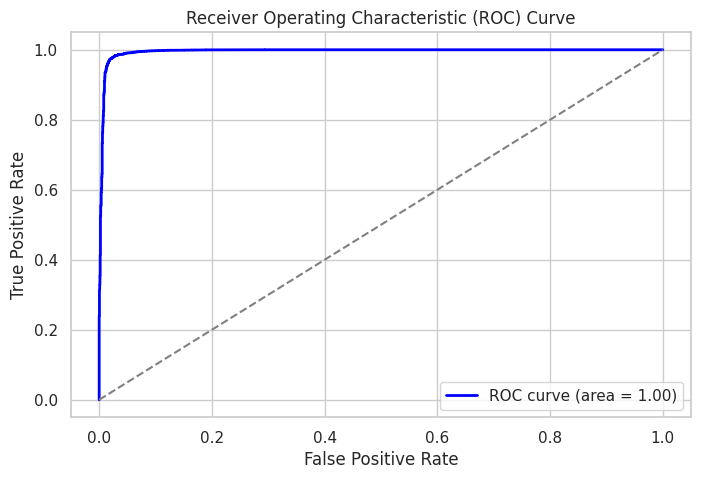

In [11]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(labels, predictions):
    fpr, tpr, _ = roc_curve(labels, predictions[:, 1])  # Assumes predictions[:, 1] for positive class
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Assuming `test_predictions` contains the predicted probabilities
plot_roc_curve(test_labels, test_predictions)
